In [1]:
import cv2
from pathlib import Path
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops, hessian_matrix, hessian_matrix_eigvals
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from scipy.ndimage import gaussian_filter
from scipy import sqrt, pi, arctan2, cos, sin
from skimage.feature import hog
from scipy.ndimage import uniform_filter 

In [2]:
def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')
        
def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

In [3]:
def read_video_to_array(video_path):
    """
    Opens an MP4 video file and returns it as an array.

    Parameters:
    - video_path (str): Path to the input MP4 video file.
    """
    cap = cv2.VideoCapture(video_path)
    
    frames = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frames.append(frame)
    
    cap.release()
    return np.array(frames)

In [4]:
def getFlow(imPrev, imNew):
    flow = cv2.calcOpticalFlowFarneback(imPrev, imNew, flow=None, pyr_scale=.5, levels=3, winsize=9, iterations=1, poly_n=3, poly_sigma=1.1, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    return flow

In [5]:
def hof(flow, orientations=9, pixels_per_cell=(8, 8),
        cells_per_block=(3, 3), visualise=False, normalise=False, motion_threshold=1.):
    """Extract Histogram of Optical Flow (HOF) for a given flow field.

    Parameters:
    - flow: The optical flow field as a 2D NumPy array of shape (height, width, 2).
    - orientations: Number of orientation bins.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - visualise: Return an image of the HOF if True.
    - normalise: Apply power law compression to normalise the flow field if True.
    - motion_threshold: Threshold for considering motion.

   

    """
    flow = np.atleast_2d(flow)

    if normalise:
        flow = np.sqrt(flow)

    gx = flow[:, :, 1]
    gy = flow[:, :, 0]

    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = np.arctan2(gy, gx) * (180 / pi) % 180

    sy, sx = flow.shape[:2]
    cx, cy = pixels_per_cell
    bx, by = cells_per_block

    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y

    orientation_histogram = np.zeros((n_cellsy, n_cellsx, orientations))
    subsample = np.index_exp[cy // 2:cy * n_cellsy:cy, cx // 2:cx * n_cellsx:cx]

    for i in range(orientations - 1):
        temp_ori = np.where(orientation < 180 / orientations * (i + 1),
                            orientation, -1)
        temp_ori = np.where(orientation >= 180 / orientations * i,
                            temp_ori, -1)

        cond2 = (temp_ori > -1) * (magnitude > motion_threshold)
        temp_mag = np.where(cond2, magnitude, 0)

        temp_filt = uniform_filter(temp_mag, size=(cy, cx))
        orientation_histogram[:, :, i] = temp_filt[subsample]

    temp_mag = np.where(magnitude <= motion_threshold, magnitude, 0)
    temp_filt = uniform_filter(temp_mag, size=(cy, cx))
    orientation_histogram[:, :, -1] = temp_filt[subsample]

    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by, bx, orientations))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[y:y+by, x:x+bx, :]
            eps = 1e-5
            normalised_blocks[y, x, :] = block / np.sqrt(block.sum()**2 + eps)

    return normalised_blocks.ravel()

In [6]:
cubes = "/home/antonkout/Documents/modules/flammable_gas_detection/release/data/propane/dataset/cubes"
cubic_files = [str(x) for x in list(Path(cubes).glob("*.mp4")) if '_gas_' in str(x)]
cubic_files.sort()
a = 18

# Define HOF parameters (adjust as needed)
orientations = 9
pixels_per_cell = (5, 5)
cells_per_block = (3, 3)
motion_threshold = 1.0  # You can adjust this threshold

cube = '/home/antonkout/Documents/modules/flammable_gas_detection/release/data/propane/dataset/cubes/cube_2675_2688_patch_13_gas.mp4'
videogen = read_video_to_array(cube)

figures_path = Path("/home/antonkout/Documents/modules/flammable_gas_detection/release/figures")

In [7]:
hog_features = []
for m in range(videogen.shape[0]):
	#Caclulation of Histogram Oriented Gradients
	fd, hog_image = hog(videogen[m], orientations=orientations, pixels_per_cell=pixels_per_cell,
						cells_per_block=cells_per_block, block_norm='L2-Hys' ,visualize=True, channel_axis=-1)
	hog_features.append(hog_image.flatten())


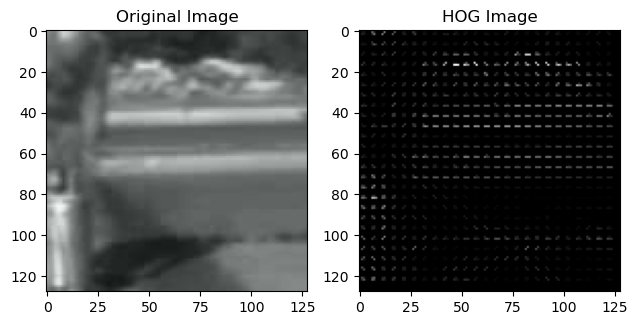

In [53]:
# Create a 1x2 subplot grid
plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Image')

plt.subplot(1, 2, 1)
plt.imshow(videogen[m])
plt.title('Original Image')

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

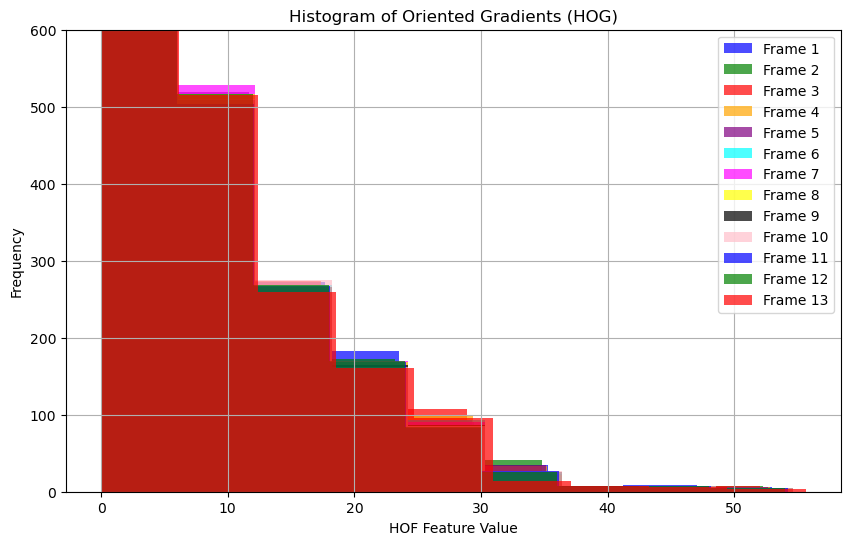

In [54]:
# Create a figure to plot all histograms
plt.figure(figsize=(10, 6))

# Define a list of colors for the histograms
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'pink']

# Iterate through all entities in hof_features and plot their histograms with different colors
for i, hog_vector in enumerate(hog_features):
    plt.hist(hog_vector, bins=orientations, alpha=0.7, color=colors[i % len(colors)], label=f'Frame {i+1}')

plt.ylim(0, 600)
plt.xlabel('HOF Feature Value')
plt.ylabel('Frequency')
plt.title('Histogram of Oriented Gradients (HOG)')
plt.grid()
plt.legend()  # Add a legend to differentiate between entities

# You can save the combined histogram to a file if needed
# plt.savefig('combined_hof_histogram.png')

plt.show()

In [55]:
# Read the video or capture frames from a camera
cap = cv2.VideoCapture(cubic_files[a])  # Replace 'video.mp4' with your video file

# Initialize variables for the first frame
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

# Create an empty list to store flow fields
flow_fields = []

while True:
    ret, frame2 = cap.read()
    if not ret:
        break

    # Convert the current frame to grayscale
    next = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    # Store the flow field
    flow_fields.append(flow)

    # Update the previous frame
    prvs = next

cap.release()

In [56]:
# Initialize a list to store HOF feature vectors
hof_features = []

# Calculate HOF features for each flow field
for flow in flow_fields:
    hof_vector = hof(flow, orientations, pixels_per_cell, cells_per_block, False, False, motion_threshold)
    hof_features.append(hof_vector)

# Convert hof_features to a NumPy array if needed
hof_features = np.array(hof_features)

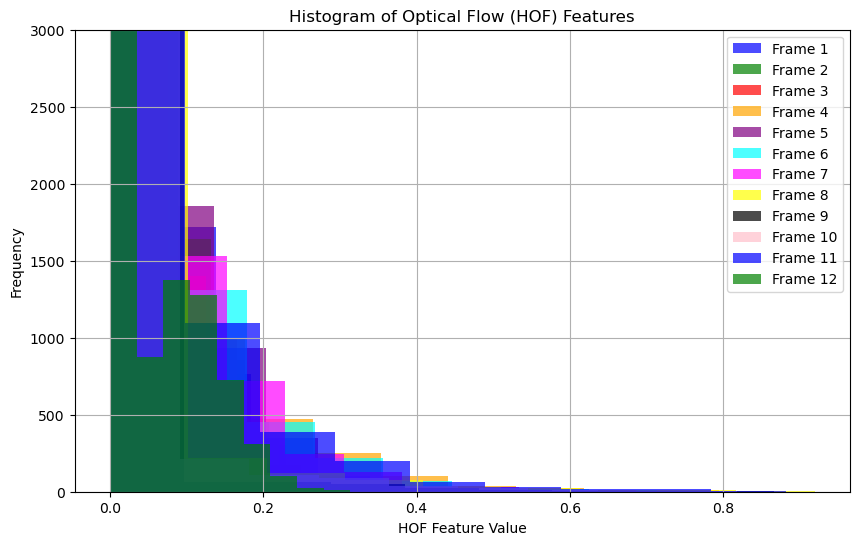

In [57]:
# Create a figure to plot all histograms
plt.figure(figsize=(10, 6))

# Define a list of colors for the histograms
colors = ['blue', 'green', 'red', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'pink']

# Iterate through all entities in hof_features and plot their histograms with different colors
for i, hof_vector in enumerate(hof_features):
    plt.hist(hof_vector, bins=orientations, alpha=0.7, color=colors[i % len(colors)], label=f'Frame {i+1}')

plt.ylim(0, 3000)
plt.xlabel('HOF Feature Value')
plt.ylabel('Frequency')
plt.title('Histogram of Optical Flow (HOF) Features')
plt.grid()
plt.legend()  # Add a legend to differentiate between entities

# You can save the combined histogram to a file if needed
# plt.savefig('combined_hof_histogram.png')

plt.show()

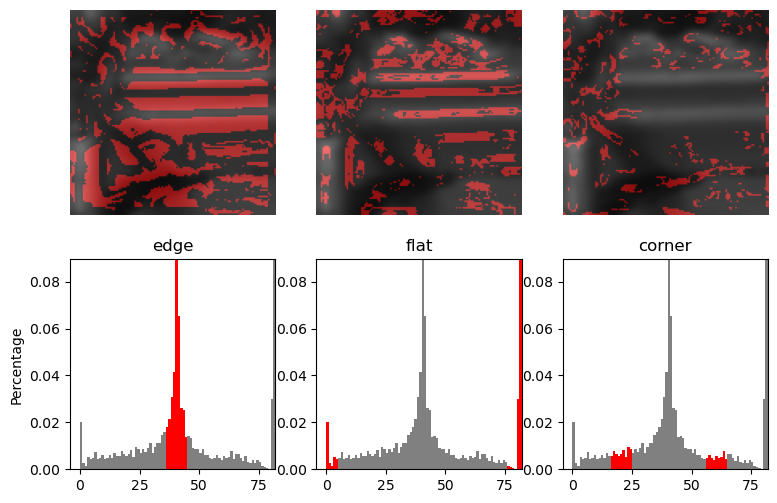

In [9]:
# Parameters for LBP calculation
radius = 5
n_points = 16 * radius
image = videogen[3][...,0]

image = gaussian_filter(image, sigma=2)

# Calculate LBP patterns
lbp = local_binary_pattern(image, n_points, radius, method='uniform')

# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

fig = figures_path / 'LBP.png'
plt.savefig(fig)

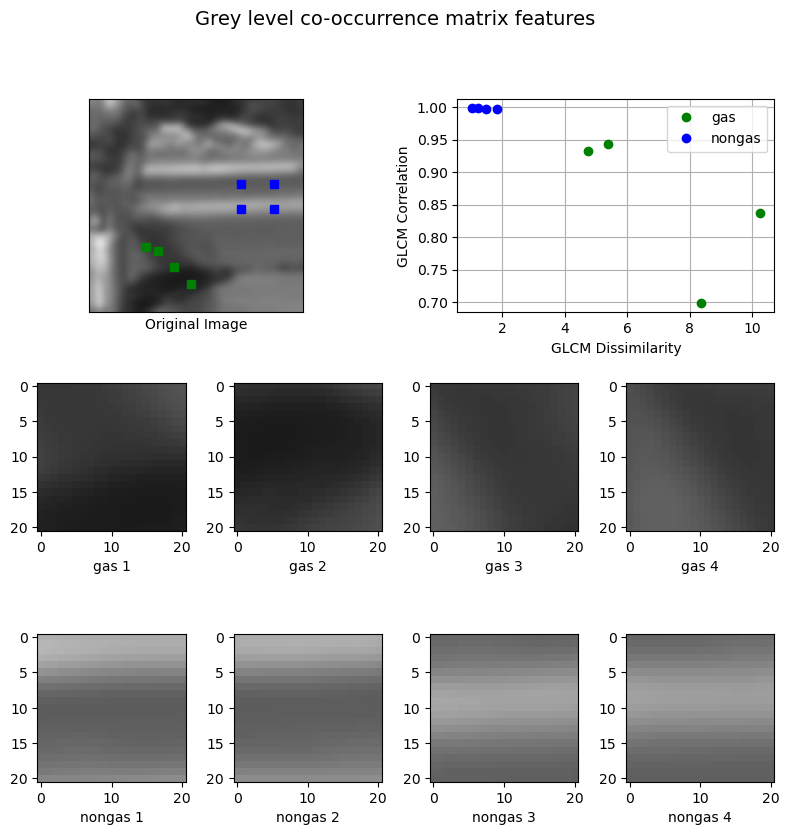

In [11]:
PATCH_SIZE = 21

# select some patches from gasy areas of the image
num_locations = 4  # You can change this to the number of locations you need
gas_locations = [(90, 40), (100, 50), (80, 30), (78, 23)]

gas_patches = []
for loc in gas_locations:
    gas_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                               loc[1]:loc[1] + PATCH_SIZE])

# select some patches from nongas areas of the image
nongas_locations = [(40, 80), (40, 100), (55, 80), (55, 100)]
nongas_patches = []
for loc in nongas_locations:
    nongas_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
                             loc[1]:loc[1] + PATCH_SIZE])

# compute some GLCM properties each patch
xs = []
ys = []
angles = np.linspace(0, 2 * np.pi, 8, endpoint=False)
for patch in (gas_patches + nongas_patches):
    glcm = graycomatrix(patch, distances=[5], angles = [0] , levels=256, #20
                        symmetric=False, normed=True)
    xs.append(graycoprops(glcm, 'dissimilarity')[0, 0])
    ys.append(graycoprops(glcm, 'correlation')[0, 0])

# create the figure
fig = plt.figure(figsize=(8, 8))

# display original image with locations of patches
ax = fig.add_subplot(3, 2, 1)
ax.imshow(image, cmap=plt.cm.gray,
          vmin=0, vmax=255)
for (y, x) in gas_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
for (y, x) in nongas_locations:
    ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
ax.set_xlabel('Original Image')
ax.set_xticks([])
ax.set_yticks([])
ax.axis('image')

# for each patch, plot (dissimilarity, correlation)
ax = fig.add_subplot(3, 2, 2)
ax.plot(xs[:len(gas_patches)], ys[:len(gas_patches)], 'go',
        label='gas')
ax.plot(xs[len(gas_patches):], ys[len(gas_patches):], 'bo',
        label='nongas')
ax.grid()
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

# display the image patches
for i, patch in enumerate(gas_patches):
    ax = fig.add_subplot(3, len(gas_patches), len(gas_patches)*1 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel(f"gas {i + 1}")

for i, patch in enumerate(nongas_patches):
    ax = fig.add_subplot(3, len(nongas_patches), len(nongas_patches)*2 + i + 1)
    ax.imshow(patch, cmap=plt.cm.gray,
              vmin=0, vmax=255)
    ax.set_xlabel(f"nongas {i + 1}")


# display the patches and plot
fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
figure = figures_path / 'Co-occurrence.png'
plt.savefig(figure)
plt.tight_layout()
plt.show()

In [13]:
glcm.flatten()

array([0., 0., 0., ..., 0., 0., 0.])

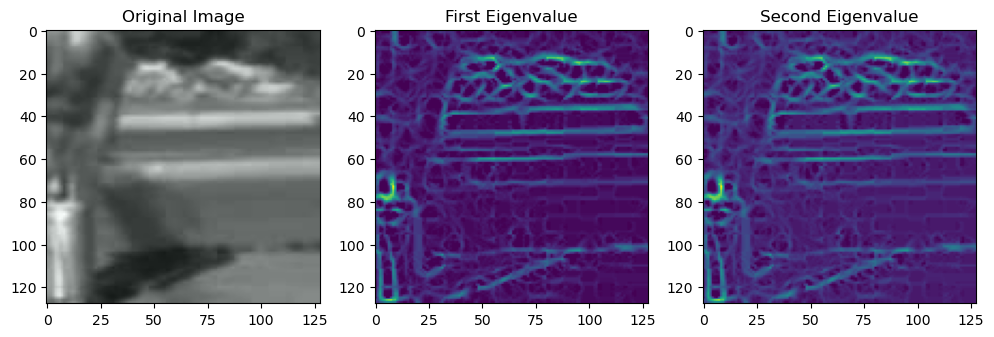

In [44]:
# Compute the Hessian matrix
H_elems = hessian_matrix(videogen[0], sigma=0.2, order='rc', use_gaussian_derivatives=True, mode='reflect', cval=0.1)

# Compute the eigenvalues
eigenvalues = hessian_matrix_eigvals(H_elems)[0]

# Create a figure with subplots to visualize the eigenvalues
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot the original image
axes[0].imshow(videogen[0], cmap='gray')
axes[0].set_title('Original Image')

# Plot the first eigenvalue
axes[1].imshow(eigenvalues[:, :, 0], cmap='viridis')
axes[1].set_title('First Eigenvalue')

# Plot the second eigenvalue
axes[2].imshow(eigenvalues[:, :, 1], cmap='viridis')
axes[2].set_title('Second Eigenvalue')
fig = figures_path / 'hessian_matrix.png'
plt.savefig(fig)
plt.show()

In [45]:
eigenvalues.flatten().shape

(49152,)

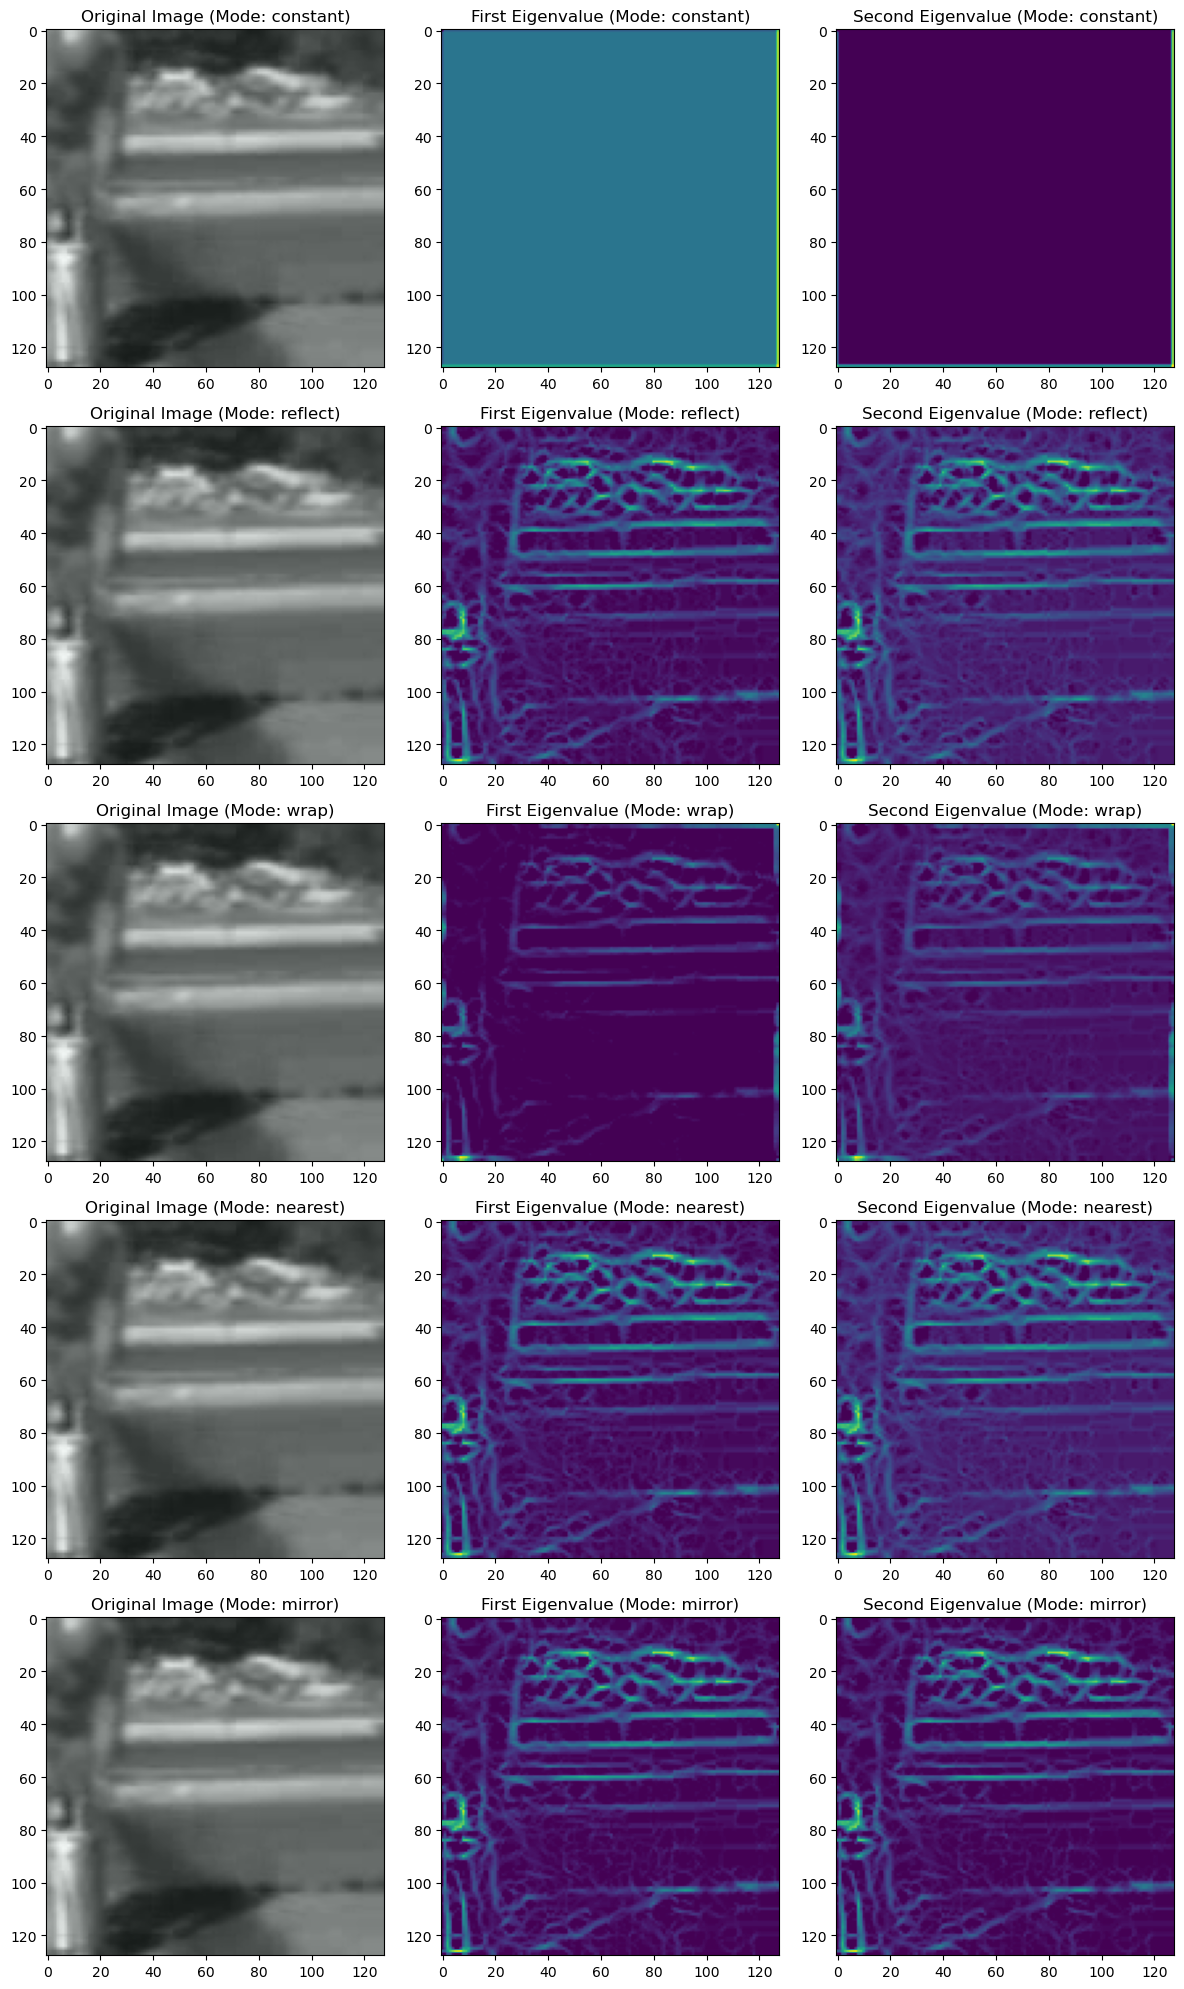

In [111]:
# Input image (you may replace this with your image data)
image = videogen[10]

# Parameters
sigma = 0.3
order = 'rc'
use_gaussian_derivatives = True
cval = 0.1

# List of boundary modes to loop through
boundary_modes = ['constant', 'reflect', 'wrap', 'nearest', 'mirror']

# Create a figure with subplots for each boundary mode
fig, axes = plt.subplots(len(boundary_modes), 3, figsize=(12, 4 * len(boundary_modes)))

# Iterate through each boundary mode
for i, mode in enumerate(boundary_modes):
    # Compute the Hessian matrix
    H_elems = hessian_matrix(image, sigma=sigma, order=order, use_gaussian_derivatives=use_gaussian_derivatives, mode=mode, cval=cval)
    
    # Compute the eigenvalues
    eigenvalues = hessian_matrix_eigvals(H_elems)[0]

    # Plot the original image
    axes[i, 0].imshow(image, cmap='gray')
    axes[i, 0].set_title('Original Image (Mode: {})'.format(mode))

    # Plot the first eigenvalue
    axes[i, 1].imshow(eigenvalues[:, :, 0], cmap='viridis')
    axes[i, 1].set_title('First Eigenvalue (Mode: {})'.format(mode))

    # Plot the second eigenvalue
    axes[i, 2].imshow(eigenvalues[:, :, 1], cmap='viridis')
    axes[i, 2].set_title('Second Eigenvalue (Mode: {})'.format(mode))

# Adjust spacing between subplots
plt.tight_layout()
figure = figures_path / 'hessian_matrix_eigenvalues.png'
plt.savefig(figure)
# Show the plots
plt.show()

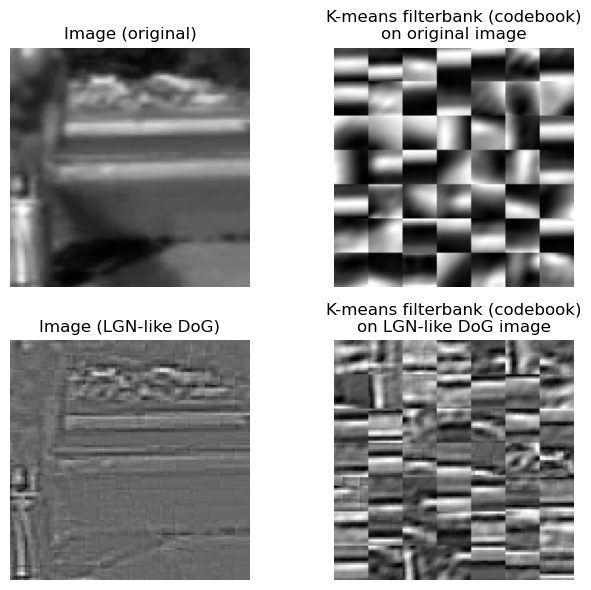

In [112]:
from scipy.cluster.vq import kmeans2
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

from skimage import data
from skimage import color
from skimage.util.shape import view_as_windows
from skimage.util import montage

patch_shape = 16,16
n_filters = 49

astro = color.rgb2gray(data.astronaut())
astro = videogen[10][...,0].astype(float)

# -- filterbank1 on original image
patches1 = view_as_windows(astro, patch_shape)
patches1 = patches1.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb1, _ = kmeans2(patches1, n_filters, minit='points')
fb1 = fb1.reshape((-1,) + patch_shape)
fb1_montage = montage(fb1, rescale_intensity=True)

# -- filterbank2 LGN-like image
astro_dog = ndi.gaussian_filter(astro, .5) - ndi.gaussian_filter(astro, 1)
patches2 = view_as_windows(astro_dog, patch_shape)
patches2 = patches2.reshape(-1, patch_shape[0] * patch_shape[1])[::8]
fb2, _ = kmeans2(patches2, n_filters, minit='points')
fb2 = fb2.reshape((-1,) + patch_shape)
fb2_montage = montage(fb2, rescale_intensity=True)

# -- plotting
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
ax = axes.ravel()

ax[0].imshow(astro, cmap=plt.cm.gray)
ax[0].set_title("Image (original)")

ax[1].imshow(fb1_montage, cmap=plt.cm.gray)
ax[1].set_title("K-means filterbank (codebook)\non original image")

ax[2].imshow(astro_dog, cmap=plt.cm.gray)
ax[2].set_title("Image (LGN-like DoG)")

ax[3].imshow(fb2_montage, cmap=plt.cm.gray)
ax[3].set_title("K-means filterbank (codebook)\non LGN-like DoG image")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()
figure = figures_path / 'kmeans_filterbank.png'
plt.savefig(figure)
plt.show()